# Differential Expression with limma-voom pipeline

In [1]:
suppressMessages({library(SummarizedExperiment)
                  library(tidyverse)
                  library(limma)
                  library(edgeR)})

## Functions

### Simple functions

In [2]:
# Function from jaffelab github
merge_rse_metrics <- function(rse) {
    stopifnot(is(rse, 'RangedSummarizedExperiment'))

    rse$overallMapRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$overallMapRate, rse$numReads)
    rse$mitoRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$mitoRate, rse$numMapped)
    rse$rRNA_rate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$rRNA_rate, rse$numMapped)
    rse$totalAssignedGene = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$totalAssignedGene, rse$numMapped)

    rse$numMapped = sapply(rse$numMapped, sum)
    rse$numReads = sapply(rse$numReads, sum)
    rse$numUnmapped = sapply(rse$numUnmapped, sum)
    rse$mitoMapped = sapply(rse$mitoMapped, sum)
    rse$totalMapped = sapply(rse$totalMapped, sum)
    return(rse)
}


save_volcanoPlot <- function(top, label, feature){
    pdf(file=paste0(feature, "/volcanoPlot_", label, ".pdf"), 8, 6)
    with(top, plot(logFC, -log10(P.Value), pch=20, cex=0.6))
    with(subset(top, adj.P.Val<=0.05), points(logFC, -log10(P.Value),
                                              pch=20, col='red', cex=0.6))
    with(subset(top, abs(logFC)>0.50), points(logFC, -log10(P.Value),
                                              pch=20, col='orange', cex=0.6))
    with(subset(top, adj.P.Val<=0.05 & abs(logFC)>0.50),
         points(logFC, -log10(P.Value), pch=20, col='green', cex=0.6))
    dev.off()
}


save_MAplot <- function(top, label, feature){
    pdf(file=paste0(feature, "/MAplot_", label, ".pdf"), 8, 6)
    with(top, plot(AveExpr, logFC, pch=20, cex=0.5))
    with(subset(top, adj.P.Val<0.05),
         points(AveExpr, logFC, col="red", pch=20, cex=0.5))
    dev.off()
}


extract_de <- function(contrast, label, efit, feature){
    top <- topTable(efit, coef=contrast, number=Inf, sort.by="P")
    top <- top[order(top$P.Value), ]
    top.fdr <- top %>% filter(adj.P.Val<=0.05)
    print(paste("Comparison for:", label))
    print(paste('There are:', dim(top.fdr)[1], 'DE features!'))
    data.table::fwrite(top, file=paste0(feature, "/diffExpr_", label, "_full.txt"), 
                       sep='\t', row.names=TRUE)
    data.table::fwrite(top.fdr, file=paste0(feature, "/diffExpr_", label, "_FDR05.txt"), 
                       sep='\t', row.names=TRUE)
    save_volcanoPlot(top, label, feature)
    save_MAplot(top, label, feature)
}


### Cached functions

In [3]:
get_mds <- function(){
    mds_file = "/ceph/projects/v4_phase3_paper/inputs/genotypes/mds/_m/LIBD_Brain_TopMed.mds"
    mds = data.table::fread(mds_file) %>%
        rename_at(.vars = vars(starts_with("C")),
                  function(x){sub("C", "snpPC", x)}) %>%
        mutate_if(is.character, as.factor)
    return(mds)
}

memMDS <- memoise::memoise(get_mds)

prep_data <- function(feature){
    sample_file = "/ceph/projects/v4_phase3_paper/inputs/phenotypes/_m/merged_phenotypes_full.csv"
    sample_data = data.table::fread(sample_file) %>% select(RNum, New_Dx) %>% filter(New_Dx != '')
    counts_lt = list("genes"="/ceph/projects/v4_phase3_paper/inputs/counts/_m/caudate_brainseq_phase3_hg38_rseGene_merged_n464.rda", 
                     "transcripts"="/ceph/projects/v4_phase3_paper/inputs/counts/_m/caudate_brainseq_phase3_hg38_rseTx_merged_n464.rda",
                     "exons"="/ceph/projects/v4_phase3_paper/inputs/counts/_m/caudate_brainseq_phase3_hg38_rseExon_merged_n464.rda",
                     "junctions"="/ceph/projects/v4_phase3_paper/inputs/counts/_m/caudate_brainseq_phase3_hg38_rseJxn_merged_n464.rda")
    tx_file = "/ceph/projects/v4_phase3_paper/inputs/counts/_m/transcripts_counts/caudate_counts.txt"
    load(counts_lt[[feature]])
    if(exists("rse_gene")){
        rse_df = rse_gene
    } else if (exists("rse_tx")){
        rse_df = rse_tx
        counts <- data.table::fread(tx_file) %>% column_to_rownames("gencodeTx") %>% 
            select(-c(txLength, gencodeID, Symbol, gene_type)) %>% as.matrix
        assays(rse_df)$counts = counts[, colnames(rse_df)]
    } else if (exists("rse_exon")){
        rse_df = rse_exon
    } else {
        rse_df = rse_jxn
    }
    keepIndex = which((rse_df$Dx %in% c("Control", "Schizo")) & 
                      rse_df$Age > 17 & rse_df$Race %in% c("AA", "CAUC"))
    rse_df = rse_df[, keepIndex]
    rse_df$Dx = factor(rse_df$Dx, levels = c("Control", "Schizo"))
    rse_df$Sex <- factor(rse_df$Sex)
    rse_df <- merge_rse_metrics(rse_df)
    colData(rse_df)$RIN = sapply(colData(rse_df)$RIN,"[",1)
    rownames(colData(rse_df)) <- sapply(strsplit(rownames(colData(rse_df)), "_"), "[", 1)
    pheno = colData(rse_df) %>% as.data.frame %>% 
        inner_join(memMDS(), by=c("BrNum"="FID")) %>% 
        distinct(RNum, .keep_all = TRUE) %>%
        inner_join(sample_data, by="RNum")
    # Generate DGE list
    x <- DGEList(counts=assays(rse_df)$counts[, pheno$RNum], 
                 genes=rowData(rse_df), samples=pheno)
    # Filter by expression
    design0 <- model.matrix(~New_Dx, data=x$samples)
    keep.x <- filterByExpr(x, design=design0)
    x <- x[keep.x, , keep.lib.sizes=FALSE]
    print(paste('There are:', sum(keep.x), 'features left!', sep=' '))
    # Normalize library size
    x <- calcNormFactors(x, method="TMM")
    return(x)
}

memo_prepData <- memoise::memoise(prep_data)

qSV_model <- function(feature){
    x <- memo_prepData(feature)
    # Design matrix
    mod = model.matrix(~New_Dx + Age + Sex + mitoRate + rRNA_rate + 
                       totalAssignedGene + RIN + overallMapRate + 
                       snpPC1 + snpPC2 + snpPC3, data = x$samples)
    colnames(mod) <- gsub("New_Dx", "", colnames(mod))
    colnames(mod) <- gsub("SexM", "Male", colnames(mod))
    colnames(mod) <- gsub("\\(Intercept\\)", "Intercept", colnames(mod))
    # Load qSV
    qsv_file = "/ceph/projects/v4_phase3_paper/inputs/counts/text_files_counts/_m/caudate/qSV_caudate.csv"
    modQsva <- mod %>% as.data.frame %>% rownames_to_column() %>%
        inner_join(data.table::fread(qsv_file), by=c("rowname"="V1")) %>% 
        rename_all(list(~str_replace_all(., 'PC', 'qPC'))) %>% 
        column_to_rownames("rowname") %>% as.matrix
    return(modQsva)
}

memo_qsvModel <- memoise::memoise(qSV_model)

get_voom <- function(feature){
    ### Preform voom
    x <- memo_prepData(feature)
    modQsva <- memo_qsvModel(feature)
    v <- voom(x[, rownames(modQsva)], modQsva, plot=TRUE)
    save(v, file=paste0(feature,'/voomSVA.RData'))
    return(v)
}

memo_voom <- memoise::memoise(get_voom)

cal_res <- function(feature){
    ### Calculate residuals
    v <- memo_voom(feature)
    null_model <- v$design %>% as.data.frame %>% 
        select(-c("Schizo_AP", "Schizo_noAP")) %>% as.matrix
    fit_res <- lmFit(v, design=null_model)
    res = v$E - ( fit_res$coefficients %*% t(null_model) )
    res_sd = apply(res, 1, sd)
    res_mean = apply(res, 1, mean)
    res_norm = (res - res_mean) / res_sd
    write.table(res_norm, file=paste0(feature, '/residualized_expression.tsv'), 
                sep="\t", quote=FALSE)
}

memo_res <- memoise::memoise(cal_res)

fit_voom <- function(feature){
    v <- memo_voom(feature)
    modQsva <- memo_qsvModel(feature)
    fit0 <- lmFit(v, modQsva)
    contr.matrix <- makeContrasts(CTLvsSZ_noAP = Schizo_noAP,
                                  CTLvsSZ_AP = Schizo_AP,
                                  levels=colnames(modQsva))
    fit <- contrasts.fit(fit0, contrasts=contr.matrix)
    esv <- eBayes(fit)
    return(esv)
}

memo_efit <- memoise::memoise(fit_voom)

## Differential Expression Analysis

[1] "There are: 25318 features left!"
[1] "Comparison for: sz_noAPVctl"
[1] "There are: 665 DE features!"
[1] "Comparison for: sz_APVctl"
[1] "There are: 2692 DE features!"
[1] "There are: 121961 features left!"
[1] "Comparison for: sz_noAPVctl"
[1] "There are: 183 DE features!"
[1] "Comparison for: sz_APVctl"
[1] "There are: 1743 DE features!"


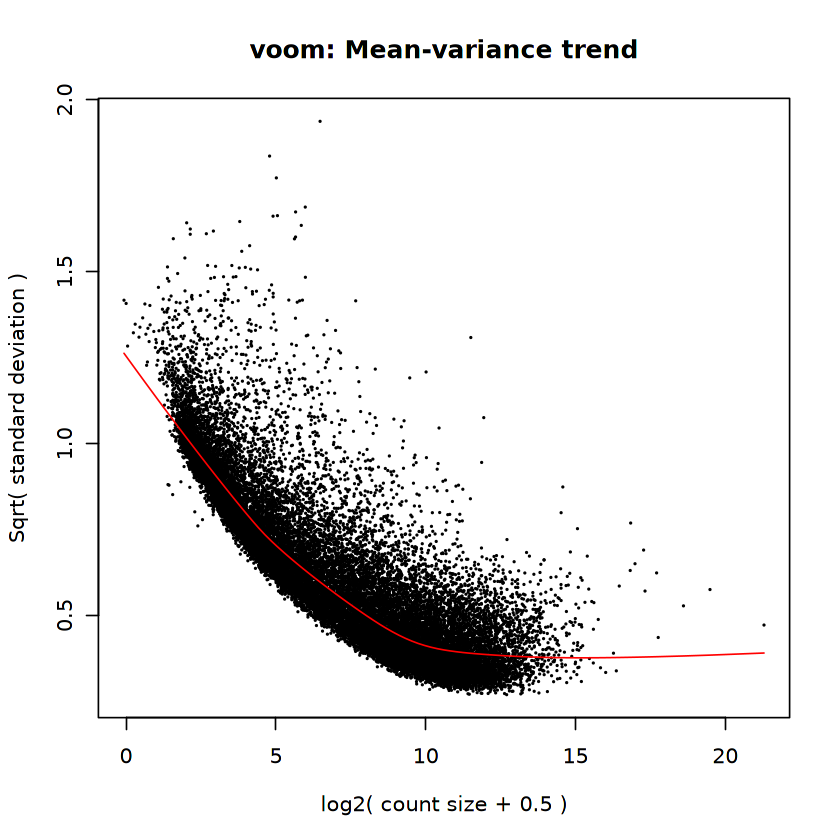

[1] "There are: 176134 features left!"


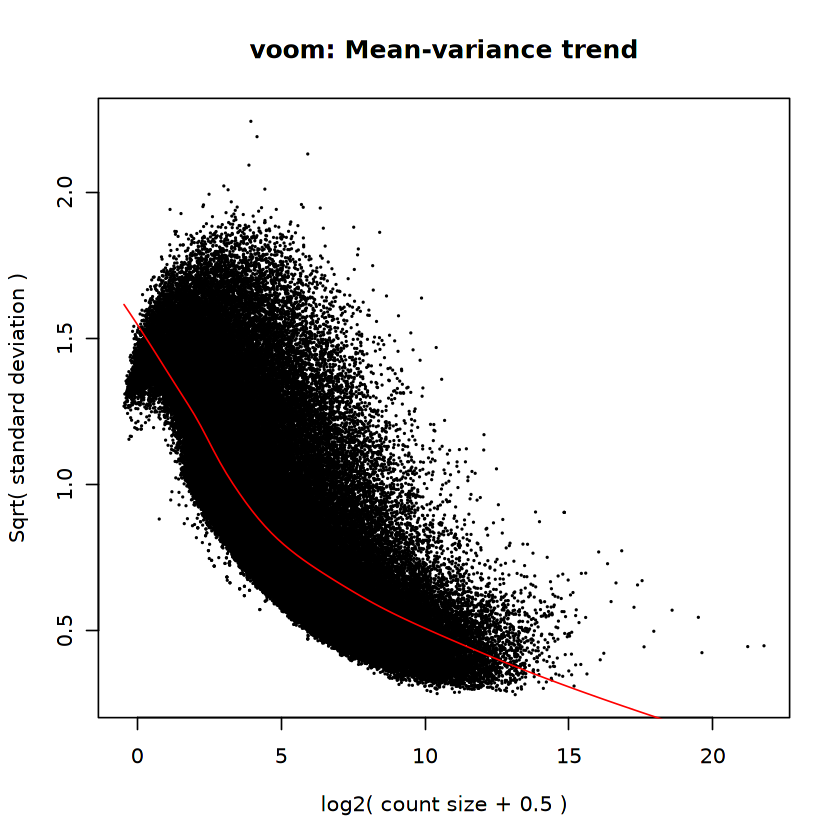

[1] "Comparison for: sz_noAPVctl"
[1] "There are: 722 DE features!"
[1] "Comparison for: sz_APVctl"
[1] "There are: 5925 DE features!"
[1] "There are: 384396 features left!"
[1] "There are: 384396 features left!"


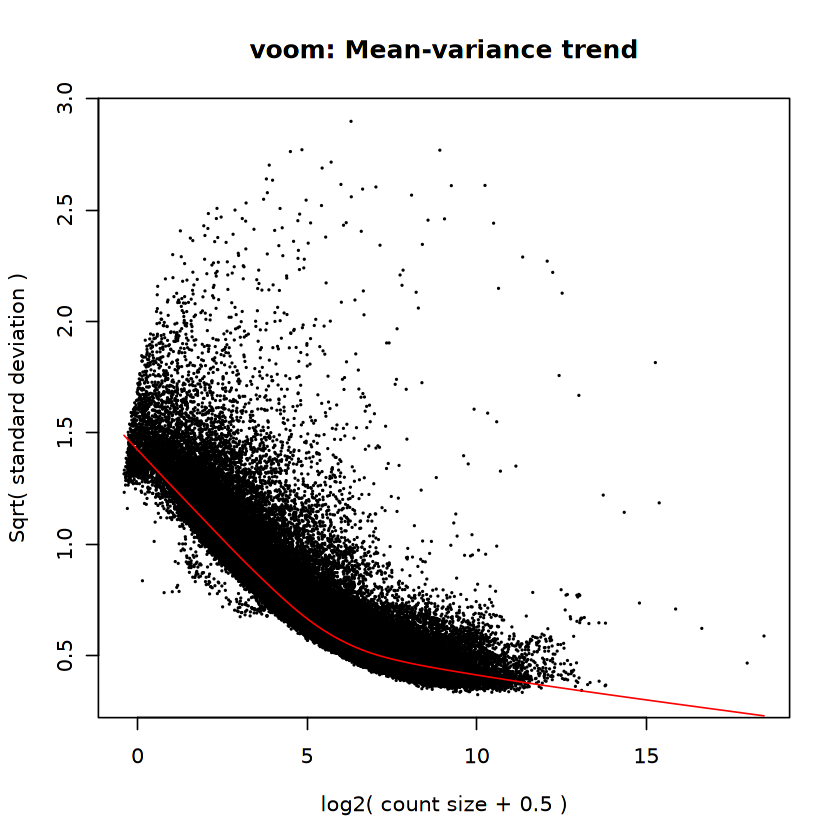

[1] "There are: 384396 features left!"
[1] "Comparison for: sz_noAPVctl"
[1] "There are: 3079 DE features!"
[1] "Comparison for: sz_APVctl"
[1] "There are: 18804 DE features!"
[1] "There are: 384396 features left!"


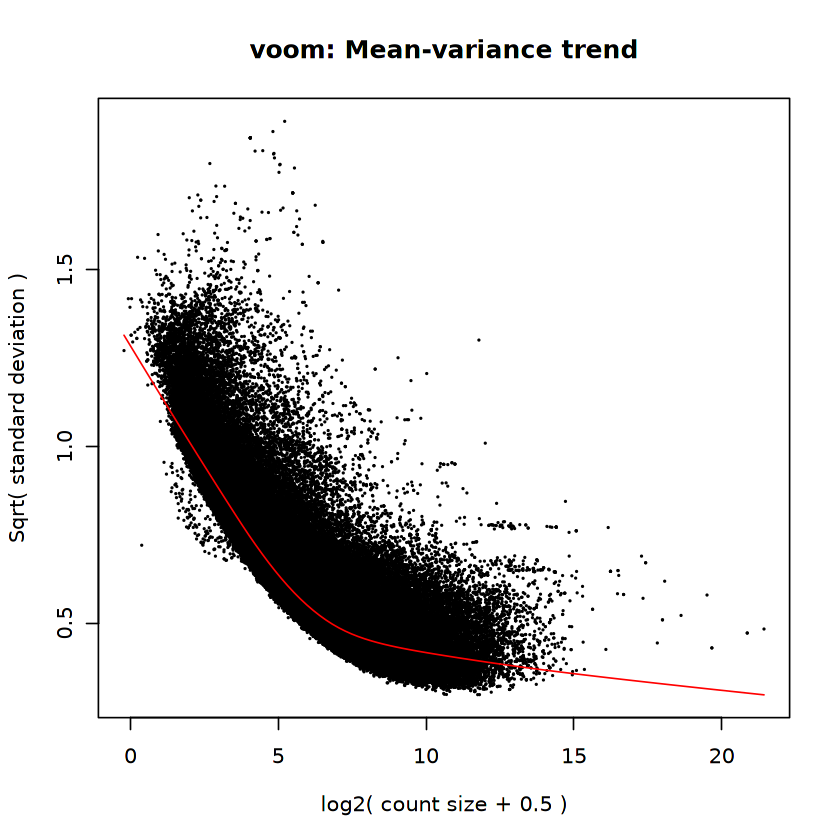

In [4]:
groups = c("sz_noAPVctl", "sz_APVctl")

for(feature in c('genes', 'transcripts', 'junctions', 'exons')){
    dir.create(feature)
    # Preform voom
    v <- memo_voom(feature)
    # Fit model and apply eBayes
    efit = memo_efit(feature)
    # Save differential expression
    for(label in seq_along(groups)){
        extract_de(label, groups[label], efit, feature)
    }
    # Calculate residuals
    memo_res(feature)
}

## Repreducibility Information

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()